In [1]:
import csv
import os
import re
import tensorflow as tf

from object_detection import evaluator
from object_detection.core import standard_fields
from object_detection.metrics import tf_example_parser
from object_detection.utils import config_util
from object_detection.utils import label_map_util

import numpy as np
# flags = tf.app.flags
# tf.logging.set_verbosity(tf.logging.INFO)

# flags.DEFINE_string('eval_dir', None, 'Directory to write eval summaries to.')
# flags.DEFINE_string('eval_config_path', None,
#                     'Path to an eval_pb2.EvalConfig config file.')
# flags.DEFINE_string('input_config_path', None,
#                     'Path to an eval_pb2.InputConfig config file.')

# FLAGS = flags.FLAGS

In [2]:
def _generate_filenames(filenames):
  result = []
  for filename in filenames:
    result += _generate_sharded_filenames(filename)
  return result
def _generate_sharded_filenames(filename):
  m = re.search(r'@(\d{1,})', filename)
  if m:
    num_shards = int(m.group(1))
    return [
        re.sub(r'@(\d{1,})', '-%.5d-of-%.5d' % (i, num_shards), filename)
        for i in range(num_shards)
    ]
  else:
    return [filename]

In [3]:
  # new format, train_out_547_1GPU1batch_lrPet, per 2 
  required_flags = ['input_config_path', 'eval_config_path', 'eval_dir']
#   for flag_name in required_flags:
#     if not getattr(FLAGS, flag_name):
#       raise ValueError('Flag --{} is required'.format(flag_name))

  configs = config_util.get_configs_from_multiple_files(
      eval_input_config_path='/root/oid_bbox_trainable_label_map_add2_validation_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_ImageID_per2_eval_547_annotation_v4/validation_input_config.pbtxt',
      eval_config_path='/root/oid_bbox_trainable_label_map_add2_validation_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_ImageID_per2_eval_547_annotation_v4/validation_eval_config.pbtxt')

  eval_config = configs['eval_config']
  input_config = configs['eval_input_config']

In [4]:
  if input_config.WhichOneof('input_reader') == 'tf_record_input_reader':
    input_paths = input_config.tf_record_input_reader.input_path

    label_map = label_map_util.load_labelmap(input_config.label_map_path)
    max_num_classes = max([item.id for item in label_map.item])
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes)

    object_detection_evaluators = evaluator.get_evaluators(
        eval_config, categories)
    # Support a single evaluator
    object_detection_evaluator = object_detection_evaluators[0]

    skipped_images = 0
    processed_images = 0

In [5]:
    for input_path in _generate_filenames(input_paths):
      tf.logging.info('Processing file: {0}'.format(input_path))

      record_iterator = tf.python_io.tf_record_iterator(path=input_path)
      data_parser = tf_example_parser.TfExampleDetectionAndGTParser()

      for string_record in record_iterator:
        tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000,
                               processed_images)
        processed_images += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        decoded_dict = data_parser.parse(example)
        print(decoded_dict)

        if decoded_dict:
          object_detection_evaluator.add_single_ground_truth_image_info(
              decoded_dict[standard_fields.DetectionResultFields.key],
              decoded_dict)
          object_detection_evaluator.add_single_detected_image_info(
              decoded_dict[standard_fields.DetectionResultFields.key],
              decoded_dict)
        else:
          skipped_images += 1
          tf.logging.info('Skipped images: {0}'.format(skipped_images))
        break
      break

INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_validation_ImageID_per2_eval_547_annotation_v4_detections.tfrecord-00000-of-00001
INFO:tensorflow:Processed 0 images...
{'groundtruth_group_of': array([1]), 'groundtruth_classes': array([278]), 'detection_boxes': array([[0.13874425, 0.42195061, 0.75658447, 0.89551741],
       [0.29179624, 0.43869928, 0.67906058, 0.9082827 ],
       [0.13089144, 0.49659657, 0.387766  , 0.8794449 ],
       [0.44645983, 0.45588329, 0.75815785, 0.88174063],
       [0.14280139, 0.53594416, 0.29694223, 0.87003195],
       [0.17965835, 0.45598012, 0.48597214, 0.8706854 ],
       [0.29661804, 0.42894569, 0.53107399, 0.87639588],
       [0.13784243, 0.51370877, 0.37471861, 0.88724232],
       [0.35557151, 0.44480723, 0.4855057 , 0.83048475],
       [0.25771782, 0.49912673, 0.38540423, 0.88924402],
       [0.14106347, 0.52247065, 0.30890256, 0.85055447],
       [0.55907613, 0.52318645, 0.68265748

In [6]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from utils import label_map_util

from utils import visualization_utils as vis_util
%matplotlib inline

In [7]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/models/research/object_detection/data', 'oid_bbox_trainable_label_map_add2.pbtxt')

NUM_CLASSES = 547

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

['Cookie: 57%']
['Cookie: 75%']
[u'Cookie', u'Cookie', u'Cookie', u'Cookie', u'Pancake', u'Cookie']
[0.75312382 0.57258976 0.39194894 0.29770768 0.20983757 0.19566062]


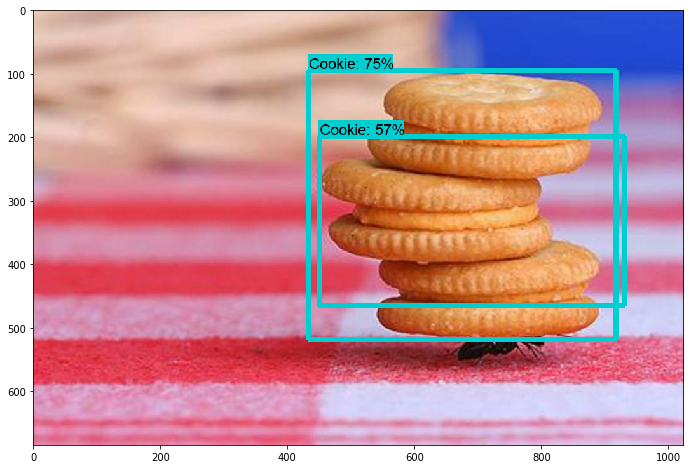

In [10]:

#.jpg # v4 model
image_path='/root/raw_images_validation/01f92a05010cabe0.jpg'

image = Image.open(image_path)
image_np = load_image_into_numpy_array(image)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  decoded_dict['detection_boxes'],
  decoded_dict['detection_classes'],
  decoded_dict['detection_scores'],
  category_index,
  instance_masks=decoded_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.5)
plt.figure(figsize=IMAGE_SIZE)


plt.imshow(image_np)
print([category_index[x]['name'] for x in decoded_dict['detection_classes'][0:6]])
print(decoded_dict['detection_scores'][0:6])





In [5]:
    for input_path in _generate_filenames(input_paths):
      tf.logging.info('Processing file: {0}'.format(input_path))

      record_iterator = tf.python_io.tf_record_iterator(path=input_path)
      data_parser = tf_example_parser.TfExampleDetectionAndGTParser()

      for string_record in record_iterator:
        tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000,
                               processed_images)
        processed_images += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        decoded_dict = data_parser.parse(example)
        print(decoded_dict)

        if decoded_dict:
          object_detection_evaluator.add_single_ground_truth_image_info(
              decoded_dict[standard_fields.DetectionResultFields.key],
              decoded_dict)
          object_detection_evaluator.add_single_detected_image_info(
              decoded_dict[standard_fields.DetectionResultFields.key],
              decoded_dict)
        else:
          skipped_images += 1
          tf.logging.info('Skipped images: {0}'.format(skipped_images))
        break
      break

INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_validation_ImageID_per2_eval_547_annotation_v4_detections.tfrecord-00000-of-00001
INFO:tensorflow:Processed 0 images...
{'groundtruth_group_of': array([1]), 'groundtruth_classes': array([278]), 'detection_boxes': array([[0.13874425, 0.42195061, 0.75658447, 0.89551741],
       [0.29179624, 0.43869928, 0.67906058, 0.9082827 ],
       [0.13089144, 0.49659657, 0.387766  , 0.8794449 ],
       [0.44645983, 0.45588329, 0.75815785, 0.88174063],
       [0.14280139, 0.53594416, 0.29694223, 0.87003195],
       [0.17965835, 0.45598012, 0.48597214, 0.8706854 ],
       [0.29661804, 0.42894569, 0.53107399, 0.87639588],
       [0.13784243, 0.51370877, 0.37471861, 0.88724232],
       [0.35557151, 0.44480723, 0.4855057 , 0.83048475],
       [0.25771782, 0.49912673, 0.38540423, 0.88924402],
       [0.14106347, 0.52247065, 0.30890256, 0.85055447],
       [0.55907613, 0.52318645, 0.68265748

In [ ]:

#coconut.jpg # v4 model
image_path='/root/raw_images_train/0024034f4d61b7d6.jpg'
image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.2)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
print(output_dict['detection_classes'][0:6])
print(output_dict['detection_scores'][0:6])